In [1]:
#Libraries to import
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.legend import Legend
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

## Importing Data & Making Dataframes
The code below was run on a subset of data from January 31st, 2020 for a few minutes from the hour of 21:00:00. The tweet ids have been retreived and hydrated from https://github.com/echen102/COVID-19-TweetIDs. https://datahub.io/core/language-codes#resource-language-codes dataset was used to map the language codes to their English names for readibility. 

In [2]:
#access the data_samples folder to get the json tweet data for the 21:00:00 hour on January 31st, 2020
#save the json file as a data frame
data_dir = Path('../..') / 'data_samples/json_files/may_sample'
json_file = str(data_dir) + '/SAMPLE-coronavirus-tweet-id-2020-05-01-00.json'
jan31_21_df = pd.read_json(json_file, lines=True)

#import the codes from dataset downloaded to get full language names
data_dir = Path('../..') / 'data_samples/'
langCodes_file = str(data_dir) + '/language-codes_csv.csv'
langCodes_df = pd.read_csv(langCodes_file)
langCodes_df = langCodes_df.sort_values('lang')

### Identifying the language of a tweet
This is done by access the 'lang' field of every tweet object in the dataframe. To perform this analysis, we add the language code to a dictionary and increment its count everytime it is encountered. This is merged with the English name of the language codes to use as labels for visualization.

In [3]:
#create a dictionary to count the number of tweets in a given language
tweetLangDict = {}

#iterate through the tweets dataframe, get the language, add it to the dictionary and increment its count
for i in range(len(jan31_21_df)):
        strkey = jan31_21_df.loc[i]['lang']
        if strkey in tweetLangDict:
            tweetLangDict[strkey] += 1
        else:
            tweetLangDict[strkey] = 1
                
#make a dataframe from the tweetLangs dictionary
columns = ['lang', 'count']
jan31_21_lang = pd.DataFrame(tweetLangDict.items(), columns=columns)
jan31_21_lang = jan31_21_lang.sort_values('lang')

In [4]:
#merge langCodes with jan31_21_df; sort the resulting dataframe
result_df = pd.merge(jan31_21_lang, langCodes_df, on="lang")
result_df = result_df.sort_values('count', ascending=False)
result_df.head()

,lang,count,English
1,en,50,English
2,es,25,Spanish
7,pt,8,Portuguese
6,ja,7,Japanese
10,und,4,undetermined


### Separate out languages that have a representation of less than 2%
If a language has a representation in the dataframe of less than 2%, create a new dataframe with those languages. This dataframe is used for two reasons, (1) to get a list of all languages below 2% and (2) to count a cumulative total number of tweets in languages that fall below 2%. A new row 'other' is added to the new dataframe with the cumulative total to represent the number of tweets that are in a language that are less than 2%.

In [5]:
#make a list to hold the languages that are less than 2%
other_lang_dict = []

#find a total count to base a percentage on
totalSum = 0.0
for i in range(len(result_df)):
    totalSum += result_df.loc[i]['count']

#calculate percentage for each column and language name
#if they are less than 2%, add them to a list to be converted to a dataframe
for i in range(len(result_df)):
    if ((result_df.loc[i]['count'] / totalSum * 100.0) < 2.0):
        other_lang_dict.append(result_df.loc[i])

#make the dataframe and get a total for all the languages under 2%
other_lang_df = pd.DataFrame.from_dict(other_lang_dict)
other_count = sum(other_lang_df['count'].tolist())

#get indices for all languages under 2% to drop from result_df
filtered_df = result_df.drop(other_lang_df.index.tolist())

#add a row to the filtered_df to account for the languages that are less than 2% (labeled as other)
otherData = {'lang': 'or', 'count': other_count, 'English': 'Other'}
filtered_df = filtered_df.append(otherData, ignore_index=True)
filtered_df = filtered_df.sort_values('count')

## Creating a pie graph of data
Pie chart code inspired by this article on TowardsDataScience: https://towardsdatascience.com/pie-charts-in-python-302de204966c

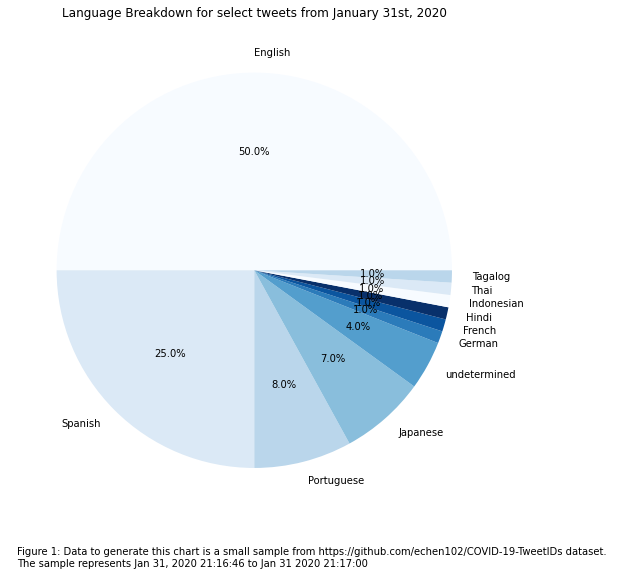

In [6]:
#get the counts and labels
lang_counts = result_df['count'].tolist()
lang_labels = result_df['English'].tolist()

#Set size & choose colors of chart
plt.figure(1, figsize=(20,20))
cmap = plt.get_cmap('Blues') #set the colors to blues - can change cmap color from Matplotlib
colors = [cmap(i) for i in np.linspace(0, 1, 8)]

#choose the location, size of plot for chart
the_grid = GridSpec(2, 2) #(2, 2) is setting the number of rows and columns

#Plat the pie chart - the_grid[0,0] is the row and column the chart will be in the plot
plt.subplot(the_grid[0, 0], aspect=1, title='Language Breakdown for select tweets from January 31st, 2020')
type_show_ids = plt.pie(lang_counts, labels=lang_labels, autopct='%1.1f%%', shadow=False, colors=colors)
plt.text(-1.2,-1.5,'Figure 1: Data to generate this chart is a small sample from https://github.com/echen102/COVID-19-TweetIDs dataset. \nThe sample represents Jan 31, 2020 21:16:46 to Jan 31 2020 21:17:00')
plt.show()

The following pie chart is filtered to group all languages that have a representation of less than 2% into other to make the pie chart labels readible.

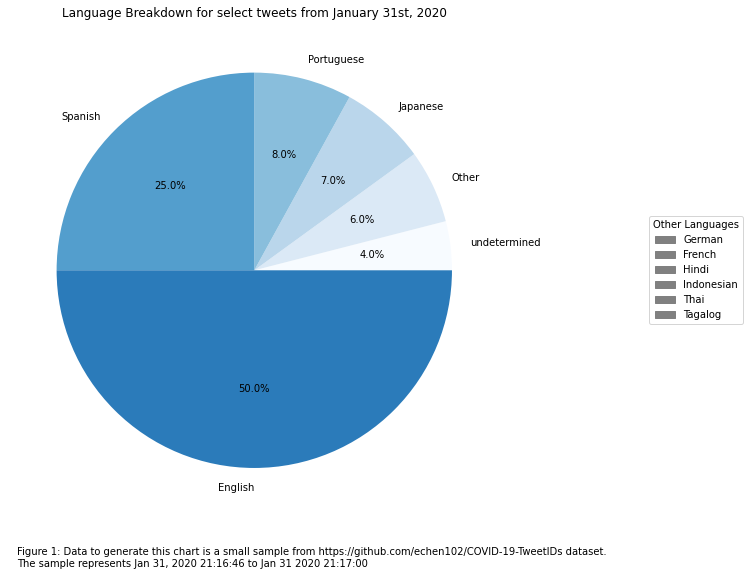

In [7]:
#get the counts and labels
lang_counts = filtered_df['count'].tolist()
lang_labels = filtered_df['English'].tolist()

#set the size of the chart
plt.figure(1, figsize=(20,20))

#Plat the pie chart - the_grid[0,0] is the row and column the chart will be in the plot
plt.subplot(the_grid[0, 0], aspect=1, title='Language Breakdown for select tweets from January 31st, 2020')
type_show_ids = plt.pie(lang_counts, labels=lang_labels, autopct='%1.1f%%', shadow=False, colors=colors)
plt.text(-1.2,-1.5,'Figure 1: Data to generate this chart is a small sample from https://github.com/echen102/COVID-19-TweetIDs dataset. \nThe sample represents Jan 31, 2020 21:16:46 to Jan 31 2020 21:17:00')

#create a customized legend by making a list of patches
patches = []
counter = 0

#for each language in other_lang_df, make a patch with it's English name and add it to the list
for i in other_lang_df.index:
    grey_patch = mpatches.Patch(color='grey', label=other_lang_df.loc[i]['English'])
    counter += 1
    patches.append(grey_patch)

#Generate a legend with the elements as the patches in the patches list
legend_elements = patches
#bbox_to_anchor will position the legend
plt.legend(handles=legend_elements, loc='right',bbox_to_anchor=(1.5, 0.5), title="Other Languages") 
plt.axis('off')
plt.show()